<h1 align="center"><b><u><font color="#2030f0">Data Mining and Knowledge Discovery (COSC 189.01 W2021)</font></u></b></h1>
<h2 align="center"><b><u><font color="#803090">Final Project: Fake News Analysis and Detection</font></u></b></h2>
<h3 align="center"><font color="gray"><b>Sanket Joshi, Masters in Computer Science, f0042hj@dartmouth.edu</b></font></h3>

<h1><b><u><font color="#60b060">Table of Contents</font></u></b></h1>

<h1><b><u><font color="#60b060">1. Introduction</font></u></b></h1>

<p>This project aims at analyzing some key characteristics and differences between real and fake news using the techniques learnt in the data mining class, and harnessing them to develop classifiers that would work on any data corpus. We first clean the data, remove obvious indicative keywords, and then pass the data to various aggregate functions to compare class level characteristics across real and fake data. We develop a classifier purely based on these aggregate engineered features and test its accuracy.</p>

<p>Next, we move on to using N-gram techniques to learn the representations of news articles and create a classifier using only the article titles. Eventually, we use the full article text to train our final set of models. We then pick the best performing model using an array of evaluation metrics. We discuss the trade-offs between the these different levels of data inputs and resultant training time on one hand with the performance on the other hand.</p>

<p>Needless to say, we only deal with a limited amount of data given the computational and time constraints. Also, there isn't a huge corpus of labelled data partially due to the objectivity of the person labelling the data itself.</p>

<h1><b><u><font color="#60b060">2. Imports</font></u></b></h1>

<p>Please make sure that the following python packages are installed before running the notebook</p>

In [1]:
import re
import string
import numpy as np
import pandas as pd
import itertools
from operator import itemgetter 

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from seaborn import heatmap, color_palette
import pylab as plt2


from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import PorterStemmer

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, plot_precision_recall_curve, confusion_matrix
from sklearn.decomposition import PCA

from joblib import dump, load

%matplotlib inline

my_stopwords = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
analyzer = SentimentIntensityAnalyzer()
stemmer = PorterStemmer()


<h1><b><u><font color="#60b060">3. Dataset</font></u></b></h1>

<p>The dataset contains roughly 45,000 articles divided equally into real and fake news. Each article contains the title, text, subject, and date.</p>

In [2]:
df_real = pd.read_csv("True.csv")
df_real["date"] = pd.to_datetime(df_real["date"], errors='coerce')
df_real["class"] = 0

df_fake = pd.read_csv("Fake.csv")
df_fake["date"] = pd.to_datetime(df_fake["date"], errors='coerce')
df_fake["class"] = 1

df = pd.concat((df_fake, df_real))
df

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,0


<h2><b><u><font color="#60b060">3.1. Cleaning</font></u></b></h2>

<p>
We remove certain words that are a give away and a feature of this dataset in particular. 
This would drastically decrease the model performance, but would make it more adaptable to new data sets
</p>

<p>
We also tokenize the text and store it into a new column for a more convenient usage.
</p>

In [3]:
df['text'] = df['text'].apply(lambda x: re.sub(
    r'([A-Z]*( )?\(Reuters\) - |21st Century Wire|Featured image( via)?)', "", x))
df['title'] = df['title'].apply(lambda x: re.sub(
    r'[\(\[][A-Z ]+[\)\]]|Video', "", x))
df['title'] = df['title'].apply(lambda x: re.sub("\(\)", "", x))

df["raw_text"] = df["text"]
df["text"] = df["text"].str.lower().apply(tokenizer.tokenize)
df["text_len"] = df["text"].apply(len)

df["raw_title"] = df["title"]
df["title"] = df["title"].str.lower().apply(tokenizer.tokenize)
df["title_len"] = df["title"].apply(len)

df = df[(df["text_len"] > 0) & (df["title_len"] > 0)]
df

,title,text,subject,date,class,raw_text,text_len,raw_title,title_len
0,"[donald, trump, sends, out, embarrassing, new,...","[donald, trump, just, couldn, t, wish, all, am...",News,2017-12-31,1,Donald Trump just couldn t wish all Americans ...,504,Donald Trump Sends Out Embarrassing New Year’...,13
1,"[drunk, bragging, trump, staffer, started, rus...","[house, intelligence, committee, chairman, dev...",News,2017-12-31,1,House Intelligence Committee Chairman Devin Nu...,316,Drunk Bragging Trump Staffer Started Russian ...,8
2,"[sheriff, david, clarke, becomes, an, internet...","[on, friday, it, was, revealed, that, former, ...",News,2017-12-30,1,"On Friday, it was revealed that former Milwauk...",609,Sheriff David Clarke Becomes An Internet Joke...,15
3,"[trump, is, so, obsessed, he, even, has, obama...","[on, christmas, day, donald, trump, announced,...",News,2017-12-29,1,"On Christmas day, Donald Trump announced that ...",474,Trump Is So Obsessed He Even Has Obama’s Name...,14
4,"[pope, francis, just, called, out, donald, tru...","[pope, francis, used, his, annual, christmas, ...",News,2017-12-25,1,Pope Francis used his annual Christmas Day mes...,422,Pope Francis Just Called Out Donald Trump Dur...,11
...,...,...,...,...,...,...,...,...,...
21412,"[fully, committed, nato, backs, new, u, s, app...","[nato, allies, on, tuesday, welcomed, presiden...",worldnews,2017-08-22,0,NATO allies on Tuesday welcomed President Dona...,471,'Fully committed' NATO backs new U.S. approach...,10
21413,"[lexisnexis, withdrew, two, products, from, ch...","[lexisnexis, a, provider, of, legal, regulator...",worldnews,2017-08-22,0,"LexisNexis, a provider of legal, regulatory an...",122,LexisNexis withdrew two products from Chinese ...,7
21414,"[minsk, cultural, hub, becomes, haven, from, a...","[in, the, shadow, of, disused, soviet, era, fa...",worldnews,2017-08-22,0,In the shadow of disused Soviet-era factories ...,324,Minsk cultural hub becomes haven from authorities,7
21415,"[vatican, upbeat, on, possibility, of, pope, f...","[vatican, secretary, of, state, cardinal, piet...",worldnews,2017-08-22,0,Vatican Secretary of State Cardinal Pietro Par...,203,Vatican upbeat on possibility of Pope Francis ...,9


<h2><b><u><font color="#60b060">3.2. Temporal Distribution</font></u></b></h2>

<p>
We see a clear spike in the fake news frequency around late 2016 and early 2017. This is a clear indication that fake news is more prevalent around election months, and could be a very useful feature.</p>

C:\Users\Sanket\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sanket\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


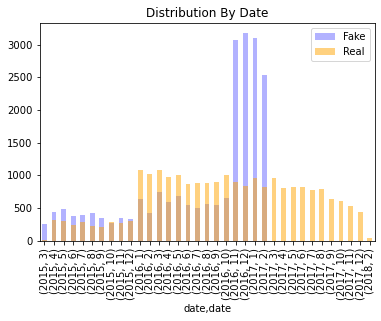

In [4]:
df_fake=df[df["class"]==0]
df_fake["date"].groupby([df_fake["date"].dt.year, df_fake["date"].dt.month]).count().plot(
    kind="bar",color="blue",alpha=0.3,label="Fake",legend=True)

df_real=df[df["class"]==1]
df_real["date"].groupby([df_real["date"].dt.year, df_real["date"].dt.month]).count().plot(
    kind="bar",color="orange",alpha=0.5,label="Real",legend=True,title="Distribution By Date")

if "date_int" in df:
    df = df.drop(columns=["date_int"])
df.loc[:,"date_int"] = df["date"].dt.year * 12 + df["date"].dt.month

<h1><b><u><font color="#60b060">4. Word Frequency Analysis in Titles</font></u></b></h1>

<p>Let's analyze the word frequency between real and fake articles in their titles</p>

In [5]:
def analyze_frequency(series, is_real):
    wc = WordCloud(random_state=0, width=1000, height=500)

    collated = series.str.cat(sep=" ")
    collated = [i for i in tokenizer.tokenize(collated) if i not in my_stopwords]

    wc.generate(" ".join(collated))
    fig = plt.figure(figsize=(12,12), facecolor = 'k')
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
    freq_dist = FreqDist(collated)
    return freq_dist

<h2><b><u><font color="#60b060">4.1. Real Titles - Word Cloud</font></u></b></h2>

<p>Looking at the term frequency in the titles of real articles, we can clearly see an exponential distribution</p>

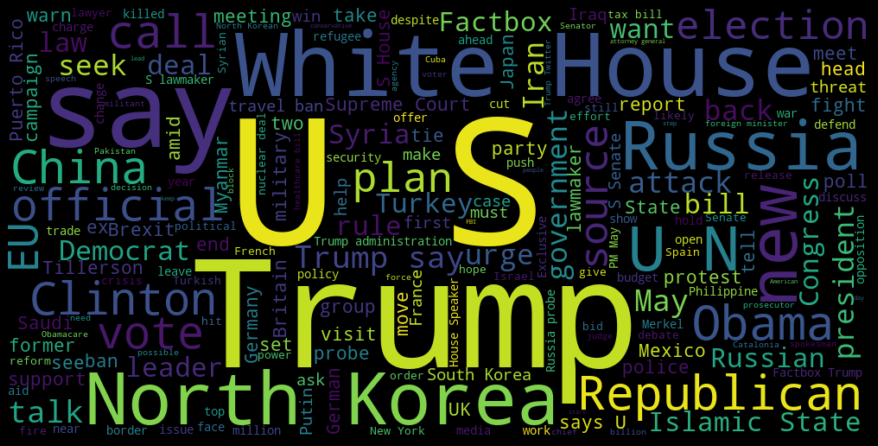

In [6]:
freq_title_real = analyze_frequency(df[df["class"]==0]["raw_title"], True)

<h2><b><u><font color="#60b060">4.2. Fake Titles - Word Cloud</font></u></b></h2>

<p>Looking at the term frequency in the titles of fake articles, we can clearly see an exponential distribution, but it is sharper than that of the real titles</p>

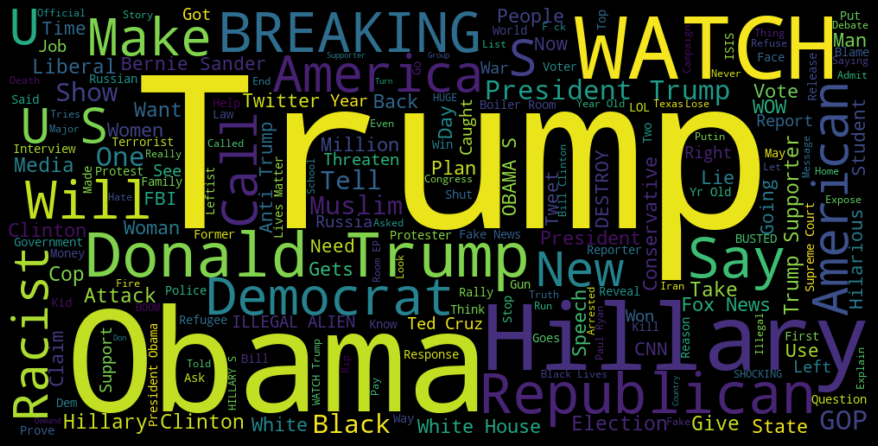

In [7]:
freq_title_fake = analyze_frequency(df[df["class"]==1]["raw_title"], False)

<h2><b><u><font color="#60b060">4.3. Vocabulary contribution from Titles</font></u></b></h2>

<p>We discover an unexpected finding, that the fake articles use a more diverse set of vocabulary. This could partly be due to the adoption of a more informal mode of communication</p>

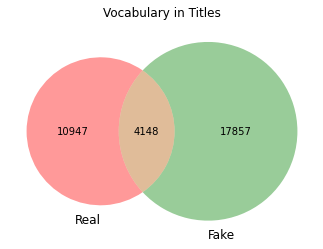

In [8]:
vocab_title_real = len(set(freq_title_real.keys()))
vocab_title_fake = len(set(freq_title_fake.keys()))
vocab_title_intersection = len(set(freq_title_real.keys()) & set(freq_title_fake.keys()))

v_real_fake = vocab_title_intersection
v_real_only = vocab_title_real - vocab_title_intersection
v_fake_only = vocab_title_fake - vocab_title_intersection

v = venn2(subsets=(v_real_only, v_fake_only, v_real_fake), set_labels = ('Real','Fake'))
plt2.title("Vocabulary in Titles")
plt2.show()

<h2><b><u><font color="#60b060">4.4. Word frequencies in Titles</font></u></b></h2>

<p>The graph perfectly represents the over-presence of certain terms in fake titles, in a much higher frequency than real titles. This is contrary to the vocabulary diversity, indicating that fake articles are more diverse, but more focused at the same time.</p>

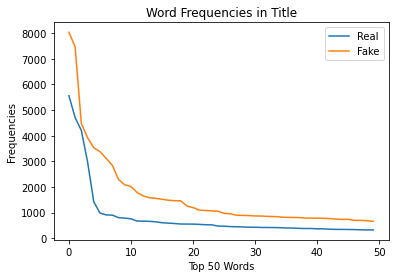

In [9]:
plt.plot(sorted(list(freq_title_real.values()), reverse=True)[:50],label="Real")
plt.plot(sorted(list(freq_title_fake.values()), reverse=True)[:50],label="Fake")
plt.title('Word Frequencies in Title')
plt.xlabel('Top 50 Words')
plt.ylabel('Frequencies')
plt.legend()
plt.show()

<h2><b><u><font color="#60b060">4.5. Exclusive words in Titles</font></u></b></h2>

<p>We see that the words exclusively present in real articles are more technical/formal. On the other hand, words exclusively present in fake articles are mostly profanity or spelling errors.</p>

In [10]:
vocab = [word.lower() for word in set(list(freq_title_real.keys()) + list(freq_title_fake.keys())) 
         if word.lower() not in my_stopwords and re.match("[a-z]+$",word)]
freq_title_diff_real = {word : (freq_title_real[word]-freq_title_fake[word])*(freq_title_real[word]*freq_title_real[word]+freq_title_fake[word]*freq_title_fake[word]) for word in vocab}
freq_title_diff_fake = {word : (freq_title_fake[word]-freq_title_real[word])*(freq_title_real[word]*freq_title_real[word]+freq_title_fake[word]*freq_title_fake[word]) for word in vocab}
res = dict(sorted(freq_title_diff_real.items(), key = itemgetter(1), reverse = True)[:100]) 
print(f"\nTop words mostly present in real article titles: \n\n{', '.join(list(res.keys()))}")
res = dict(sorted(freq_title_diff_fake.items(), key = itemgetter(1), reverse = True)[:100])
print(f"\nTop words mostly present in fake article titles: \n\n{', '.join(list(res.keys()))}")


Top words mostly present in real article titles: 

says, bill, tax, election, deal, new, vote, talks, court, minister, calls, president, government, leader, chief, police, probe, plan, sanctions, official, military, nuclear, ban, law, campaign, urges, trade, state, party, security, may, attack, lawmakers, opposition, presidential, sources, foreign, healthcare, meet, governor, say, budget, panel, border, visit, crisis, could, would, travel, top, media, seeks, officials, fight, meeting, rights, ex, administration, poll, aid, wants, first, defense, killed, policy, tells, coalition, back, war, anti, two, ahead, end, ties, next, leaders, reform, warns, move, seek, support, rules, bid, climate, report, case, million, missile, immigration, attacks, discuss, must, call, amid, parliament, political, independence, nominee, pick, source

Top words mostly present in fake article titles: 

ck, going, cking, like, vs, guest, us, white, mails, think, know, cks, mail, guests, f, hole, tch, gonna, nev

<h1><b><u><font color="#60b060">5. Word Frequency Analysis in Text</font></u></b></h1>

<p>Let's analyze the word frequency between real and fake articles in their text</p>

<h2><b><u><font color="#60b060">5.1. Real Text - Word Cloud</font></u></b></h2>

<p>Looking at the term frequency in the text of real articles, we do see an exponential distribution again, and it seems to be a bit sharper than that in the titles</p>

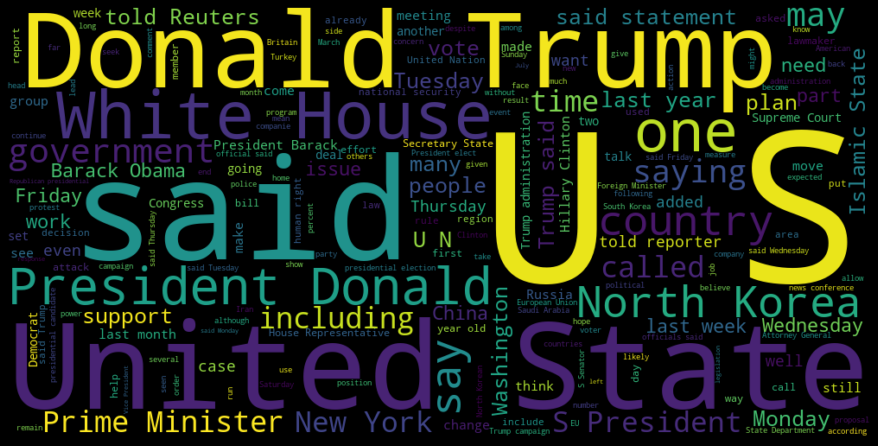

In [11]:
freq_text_real = analyze_frequency(df[df["class"]==0]["raw_text"], True)

<h2><b><u><font color="#60b060">5.2. Fake Text - Word Cloud</font></u></b></h2>

<p>Looking at the term frequency in the text of fake articles, the exponential nature distribution persists, but is surprisingly much less than that of real articles. This could partly be due to the lexical diversity and informality.</p>

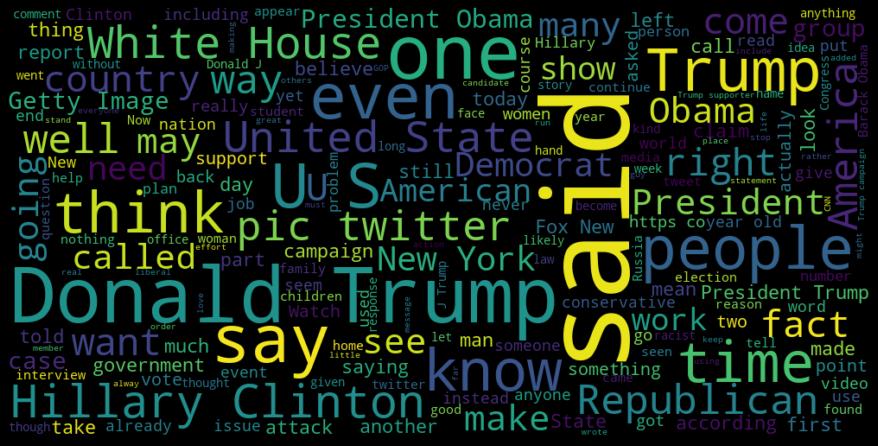

In [12]:
freq_text_fake = analyze_frequency(df[df["class"]==1]["raw_text"], False)

<h2><b><u><font color="#60b060">5.3. Vocabulary contribution from Text</font></u></b></h2>

<p>We see a surprisingly similar distribution of vocabulary in text with respect to titles.</p>

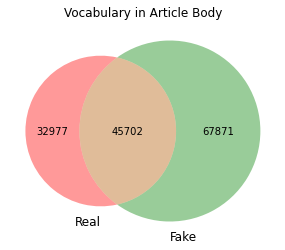

In [13]:
vocab_text_real = len(set(freq_text_real.keys()))
vocab_text_fake = len(set(freq_text_fake.keys()))
vocab_text_intersection = len(set(freq_text_real.keys()) & set(freq_text_fake.keys()))

v_real_fake = vocab_text_intersection
v_real_only = vocab_text_real - vocab_text_intersection
v_fake_only = vocab_text_fake - vocab_text_intersection

v = venn2(subsets=(v_real_only, v_fake_only, v_real_fake), set_labels = ('Real','Fake'))
plt2.title("Vocabulary in Article Body")
plt2.show()

<h2><b><u><font color="#60b060">5.4. Word frequencies in Text</font></u></b></h2>

<p>The graph is not as interesting as the word frequencies in titles. The distributions are fairly similar between real and fake texts</p>

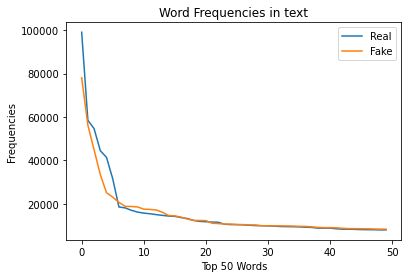

In [14]:
plt.plot(sorted(list(freq_text_real.values()), reverse=True)[:50],label="Real")
plt.plot(sorted(list(freq_text_fake.values()), reverse=True)[:50],label="Fake")
plt.title('Word Frequencies in text')
plt.xlabel('Top 50 Words')
plt.ylabel('Frequencies')
plt.legend()
plt.show()

<h2><b><u><font color="#60b060">5.5. Exclusive words in Text</font></u></b></h2>

<p>In the case of text, we do not see a clear divide between the exclusive words. This indicates that the titles are more of a clickbait in fake titles, not the content not as much!</p>

In [15]:
vocab = [word.lower() for word in set(list(freq_text_real.keys()) + list(freq_text_fake.keys())) 
         if word.lower() not in my_stopwords and re.match("[a-z]+$",word)]
freq_text_diff_real = {word : (freq_text_real[word]-freq_text_fake[word])*(freq_text_real[word]*freq_text_real[word]+freq_text_fake[word]*freq_text_fake[word]) for word in vocab}
freq_text_diff_fake = {word : (freq_text_fake[word]-freq_text_real[word])*(freq_text_real[word]*freq_text_real[word]+freq_text_fake[word]*freq_text_fake[word]) for word in vocab}
res = dict(sorted(freq_text_diff_real.items(), key = itemgetter(1), reverse = True)[:100]) 
print(f"\nTop words mostly present in real article texts: \n\n{', '.join(list(res.keys()))}")
res = dict(sorted(freq_text_diff_fake.items(), key = itemgetter(1), reverse = True)[:100]) 
print(f"\nTop words mostly present in fake article texts: \n\n{', '.join(list(res.keys()))}")



Top words mostly present in real article texts: 

said, would, government, year, told, state, could, last, election, percent, two, also, former, party, tax, officials, military, week, new, including, statement, security, administration, presidential, since, official, court, month, bill, deal, trade, vote, foreign, support, nuclear, million, law, countries, spokesman, policy, leader, next, group, whether, leaders, meeting, talks, reporters, three, billion, sanctions, according, saying, office, forces, political, minister, comment, opposition, lawmakers, expected, region, called, plan, decision, top, groups, border, legislation, economic, senior, rights, move, companies, led, power, agency, city, chief, federal, national, killed, states, international, coalition, budget, added, al, members, held, part, parliament, ruling, among, plans, end, capital, missile, earlier, agreement

Top words mostly present in fake article texts: 

people, one, like, even, time, know, media, get, right, goin

<h1><b><u><font color="#60b060">6. Sentiment Analysis in Titles</font></u></b></h1>

<p>Let's analyze the distribution of sentiments between real and fake</p>

In [16]:
df.loc[:,"sentiments"] = df["raw_title"].apply(lambda x: analyzer.polarity_scores(x).values())

C:\Users\Sanket\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sanket\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
sentiments = ["neg","neu","pos","compound"]
for i, sentiment in enumerate(sentiments):
    df.loc[:, sentiment] = df["sentiments"].apply(lambda x: list(x)[i])

<h2><b><u><font color="#60b060">6.1. Negative</font></u></b></h2>

<p>Fake is lower in magnitude, but lesser zeroes than real</p>

<AxesSubplot:title={'center':'Negative'}, ylabel='Frequency'>

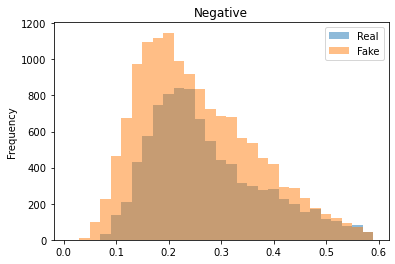

In [18]:
bins=np.arange(0.01, 0.6, 0.02)
df[(df["class"]==0)]["neg"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Negative")
df[(df["class"]==1)]["neg"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake",title="Negative")

<h2><b><u><font color="#60b060">6.2. Positive</font></u></b></h2>

<p>Fake is lower in magnitude, but similar zeroes to real</p>

<AxesSubplot:title={'center':'Positive'}, ylabel='Frequency'>

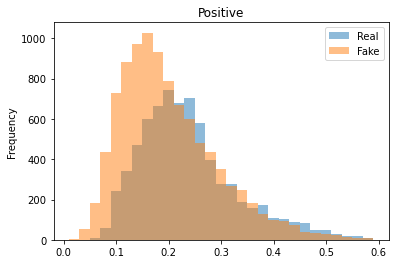

In [19]:
bins=np.arange(0.01, 0.6, 0.02)
df[(df["class"]==0)]["pos"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Positive")
df[(df["class"]==1)]["pos"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake",title="Positive")

<h2><b><u><font color="#60b060">6.3. Neutral</font></u></b></h2>

<p>Fake is higher in frequency than real</p>

<AxesSubplot:title={'center':'Neutral'}, ylabel='Frequency'>

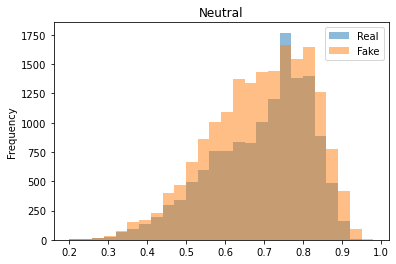

In [20]:
bins=np.arange(0.2, 1, 0.03)
df[(df["class"]==0)]["neu"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Neutral")
df[(df["class"]==1)]["neu"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake",title="Neutral")

<h2><b><u><font color="#60b060">6.4. Compound</font></u></b></h2>

<p>Fake is higher in magnitude than real</p>

<AxesSubplot:title={'center':'Compound'}, ylabel='Frequency'>

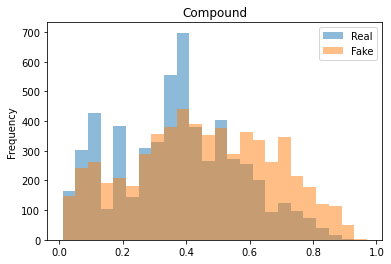

In [21]:
bins=np.arange(0.01, 1, 0.04)
df[(df["class"]==0)]["compound"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Compound")
df[(df["class"]==1)]["compound"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake",title="Compound")

<h1><b><u><font color="#60b060">7. Extracting Engineered Features</font></u></b></h1>

<p>Let's introduce some more features that could be used to strengthen our classification</p>

<h2><b><u><font color="#60b060">7.1. Title Length</font></u></b></h2>

<p>Real article titles are overall shorter than fake titles.</p>

<AxesSubplot:title={'center':'Title Word Count'}, ylabel='Frequency'>

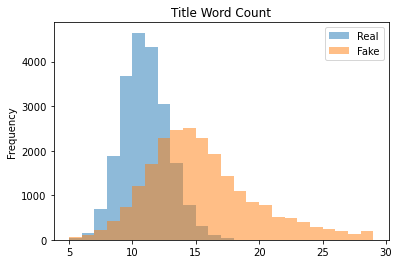

In [22]:
bins=np.arange(5, 30, 1)
df[(df["class"]==0)]["title_len"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Title Word Count")
df[(df["class"]==1)]["title_len"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<h2><b><u><font color="#60b060">7.2. Text Length</font></u></b></h2>

<p>Real article lengths surprisingly do not follow a bell curve, but have to distinct peaks. Overall, fake articles are longer.</p>

<AxesSubplot:title={'center':'Text Word Count'}, ylabel='Frequency'>

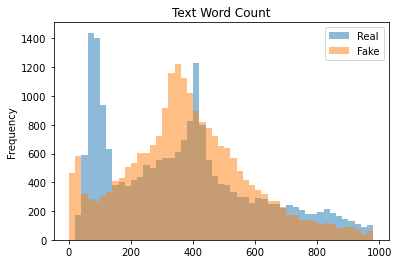

In [23]:
bins=np.arange(0, 1000, 20)
df[(df["class"]==0) & (df["text_len"] < 2000) & (df["text_len"] > 0)]["text_len"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Text Word Count")
df[(df["class"]==1) & (df["text_len"] < 2000) & (df["text_len"] > 0)]["text_len"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<h2><b><u><font color="#60b060">7.3. Relevant Text Length</font></u></b></h2>

<p>Real article lengths again, do not follow a bell curve, but have to distinct peaks. But in terms of relevance, fake articles are longer.</p>

<ipython-input-24-a0532dfd920d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_minus_stop"] = df["text"].apply(lambda x: [i for i in x if i not in my_stopwords])
<ipython-input-24-a0532dfd920d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_minus_stop_len"] = df["text_minus_stop"].apply(len)


<AxesSubplot:title={'center':'Text Word Count without stopwords'}, ylabel='Frequency'>

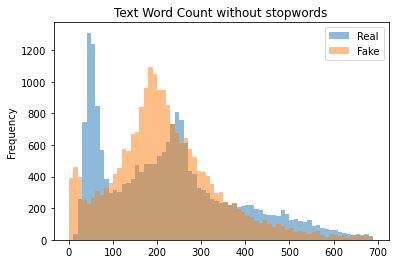

In [24]:
df["text_minus_stop"] = df["text"].apply(lambda x: [i for i in x if i not in my_stopwords])
df["text_minus_stop_len"] = df["text_minus_stop"].apply(len)
bins=np.arange(0, 700, 10)
df[(df["class"]==0) & (df["text_minus_stop_len"] < 1000) & (df["text_minus_stop_len"] > 0)]["text_minus_stop_len"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Text Word Count without stopwords")
df[(df["class"]==1) & (df["text_minus_stop_len"] < 1000) & (df["text_minus_stop_len"] > 0)]["text_minus_stop_len"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<h2><b><u><font color="#60b060">7.4. Title to Text ratio</font></u></b></h2>

<p>Fake titles are generally longer with respect to the content size. This might indicate sensationalism and clickbait titles</p>

<ipython-input-25-42b7936135ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_to_text_ratio"] = df["title_len"] / df["text_len"]


<AxesSubplot:title={'center':'Title to text ratio'}, ylabel='Frequency'>

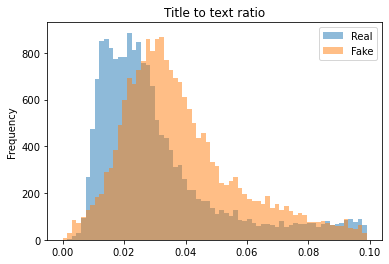

In [25]:
df["title_to_text_ratio"] = df["title_len"] / df["text_len"]
bins=np.arange(0, 0.1, 0.0015)
df[df["class"]==0]["title_to_text_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Title to text ratio")
df[df["class"]==1]["title_to_text_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<h2><b><u><font color="#60b060">7.5. Relevant Text Proportion</font></u></b></h2>

<p>Overall, real articles use slightly more relevant words than fake articles. This might be partly due to the succintness and formalism.</p>

<ipython-input-26-308c62e44809>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_relevant_word_ratio"] = df["text_minus_stop_len"]/df["text_len"]


<AxesSubplot:title={'center':'Text stop word ratio'}, ylabel='Frequency'>

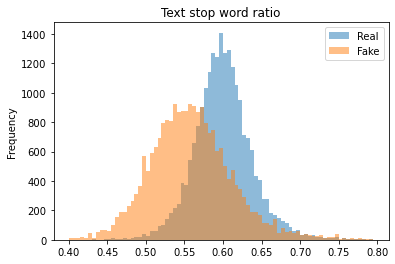

In [26]:
df["text_relevant_word_ratio"] = df["text_minus_stop_len"]/df["text_len"]
bins=np.arange(0.4, 0.8, 0.005)
df[df["class"]==0]["text_relevant_word_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Text stop word ratio")
df[df["class"]==1]["text_relevant_word_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<h2><b><u><font color="#60b060">7.6. Punctuations</font></u></b></h2>

<p>Overall, real articles use slightly more punctuations</p>
<p>But when you specifically look at exclamation marks and question marks, most of them come from fake news, which could prove to be a great feature</p>

<ipython-input-27-5ba9d5e7671b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_punct_ratio"] = df["raw_text"].apply(get_punctuation_ratio)


<AxesSubplot:title={'center':'Punctuation ratio'}, ylabel='Frequency'>

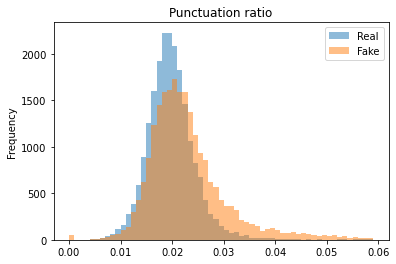

In [27]:
def get_punctuation_ratio(text):
    full_len = len(text)
    full_len_w_o_punct = len(re.sub(f'[{string.punctuation}]', '', text))
    return 1 - full_len_w_o_punct / full_len

df["text_punct_ratio"] = df["raw_text"].apply(get_punctuation_ratio)
bins=np.arange(0, 0.06, 0.001)
df[df["class"]==0]["text_punct_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Punctuation ratio")
df[df["class"]==1]["text_punct_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<ipython-input-28-e6efd65e94e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_exclamation_ratio"] = df["raw_text"].apply(lambda x: len(re.findall("!",x))/len(x))


<AxesSubplot:title={'center':'Exclamation ratio'}, ylabel='Frequency'>

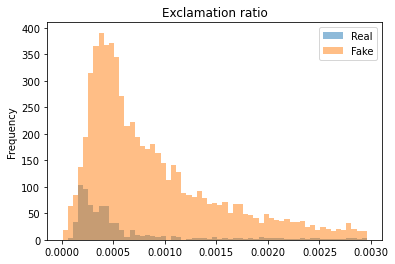

In [28]:
df["text_exclamation_ratio"] = df["raw_text"].apply(lambda x: len(re.findall("!",x))/len(x))
bins=np.arange(0.00001, 0.003, 0.00005)
df[df["class"]==0]["text_exclamation_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Exclamation ratio")
df[df["class"]==1]["text_exclamation_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<ipython-input-29-6708e55059f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_question_ratio"] = df["raw_text"].apply(lambda x: len(re.findall("\?",x))/len(x))


<AxesSubplot:title={'center':'Question ratio'}, ylabel='Frequency'>

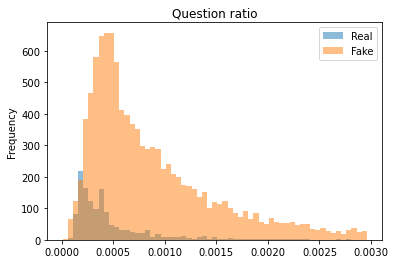

In [29]:
df["text_question_ratio"] = df["raw_text"].apply(lambda x: len(re.findall("\?",x))/len(x))
bins=np.arange(0.00001, 0.003, 0.00005)
df[df["class"]==0]["text_question_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Real",title="Question ratio")
df[df["class"]==1]["text_question_ratio"].plot.hist(
    bins=bins,alpha=0.5,legend=True,label="Fake")

<h1><b><u><font color="#60b060">8. Classification with Engineered Features</font></u></b></h1>

<p>We see that without using costly techniques like ngram analysis, we can use the engineeered features to get accuracies upto 94%.</p>

In [30]:
engineered_features = ["text_len","title_len","text_minus_stop_len", "date_int",
                       "text_relevant_word_ratio","title_to_text_ratio",
                       "text_punct_ratio", "text_exclamation_ratio", "text_question_ratio",
                       "neg","neu","pos","compound"]

df[['text','title'] + engineered_features].head()

,text,title,text_len,title_len,text_minus_stop_len,date_int,text_relevant_word_ratio,title_to_text_ratio,text_punct_ratio,text_exclamation_ratio,text_question_ratio,neg,neu,pos,compound
0,"[donald, trump, just, couldn, t, wish, all, am...","[donald, trump, sends, out, embarrassing, new,...",504,13,297,24216,0.589286,0.025794,0.041825,0.002074,0.003111,0.371,0.629,0.000,-0.7096
1,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus...",316,8,185,24216,0.585443,0.025316,0.020548,0.000000,0.000000,0.255,0.745,0.000,-0.3400
2,"[on, friday, it, was, revealed, that, former, ...","[sheriff, david, clarke, becomes, an, internet...",609,15,362,24216,0.594417,0.024631,0.041145,0.000556,0.001112,0.183,0.699,0.118,-0.2960
3,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama...",474,14,290,24216,0.611814,0.029536,0.042538,0.000000,0.000360,0.142,0.858,0.000,-0.2484
4,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru...",422,11,212,24216,0.502370,0.026066,0.017050,0.000000,0.000000,0.000,1.000,0.000,0.0000


<h2><b><u><font color="#60b060">8.1. Classification</font></u></b></h2>

<p>Let's test a few different models</p>

In [31]:
def classification_with_engineered_features(model, df, engineered_features):

    xtr, xts, ytr, yts = train_test_split(df[engineered_features], df["class"], test_size=0.1)

    model.fit(xtr, ytr)
    scoring={
        "acc": make_scorer(accuracy_score),
        "f1": make_scorer(f1_score),
        "f1_weighted": make_scorer(f1_score, average="weighted")
    }
    cv = cross_validate(estimator=model, X=xtr, y=ytr, cv=5, scoring=scoring, return_train_score=True)
    preds = model.predict(xts)
    f1 = f1_score(yts, preds, average='weighted')
    plot_precision_recall_curve(model, xts, yts)
    print(f"Model: {str(model)} |",
          f"Accuracy: {cv['test_acc'].mean():.3%} |",
          f"F1: {cv['test_f1'].mean():.3%} |",
          f"Weighted F1: {cv['test_f1_weighted'].mean():.3%} |",
          f"Test F1: {f1:.3%}\n")
    
    return preds, f1, yts

Model: DecisionTreeClassifier() | Accuracy: 91.372% | F1: 91.695% | Weighted F1: 91.369% | Test F1: 92.130%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 94.328% | F1: 94.513% | Weighted F1: 94.328% | Test F1: 94.597%

Model: KNeighborsClassifier(n_neighbors=3) | Accuracy: 85.519% | F1: 85.763% | Weighted F1: 85.523% | Test F1: 86.394%



C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression() | Accuracy: 81.827% | F1: 81.750% | Weighted F1: 81.824% | Test F1: 81.419%



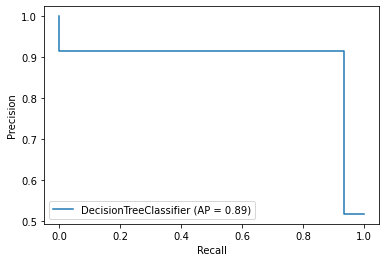

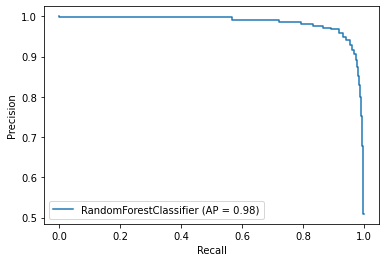

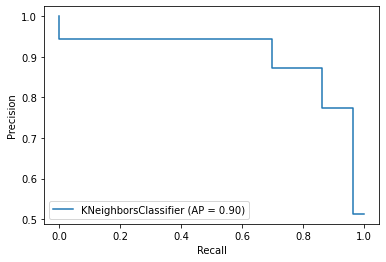

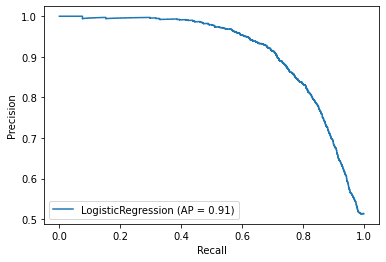

In [32]:
models = [DecisionTreeClassifier(), RandomForestClassifier(n_estimators=20), 
          KNeighborsClassifier(n_neighbors=3), LogisticRegression()]

best_model = models[0]
best_f1 = 0
best_preds = None
best_yts = None

for model in models:
    preds, f1, yts = classification_with_engineered_features(model, df, engineered_features)
    if f1 > best_f1:
        best_model = model
        best_f1 = f1
        best_preds = preds
        best_yts = yts


<h2><b><u><font color="#60b060">8.2. Best Model</font></u></b></h2>

In [33]:
print(f"Best Model: {str(best_model)}, Weighted F1: {best_f1:.3%}")

Best Model: RandomForestClassifier(n_estimators=20), Weighted F1: 94.597%


<h2><b><u><font color="#60b060">8.3. Confusion Matrix</font></u></b></h2>

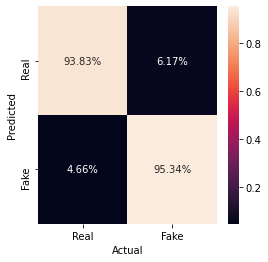

In [34]:
cm = confusion_matrix(best_yts, best_preds)
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(4,4))
heatmap(cmn, annot=True, fmt='.2%', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show(block=False)

<h1><b><u><font color="#60b060">9. Feature Importance</font></u></b></h1>

<p>Let's do some analysis using various approaches to find out which features contribute most to the model accuracy</p>

<h2><b><u><font color="#60b060">9.1. Via Elimination</font></u></b></h2>

<p>Let's find out the dip in accuracies by excluding each feature to find their importance. </p>
<p>We see that this excercise is not that helpful since we do not see a drop of more than 2%</p>

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 94.200% | F1: 94.378% | Weighted F1: 94.200% | Test F1: 94.304%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.728% | F1: 93.953% | Weighted F1: 93.727% | Test F1: 94.778%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 94.158% | F1: 94.333% | Weighted F1: 94.158% | Test F1: 94.891%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 92.309% | F1: 92.501% | Weighted F1: 92.310% | Test F1: 92.857%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.088% | F1: 93.289% | Weighted F1: 93.088% | Test F1: 93.739%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 94.168% | F1: 94.357% | Weighted F1: 94.168% | Test F1: 94.190%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.896% | F1: 94.080% | Weighted F1: 93.896% | Test F1: 94.734%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.640% | F1: 93.826% | Weighted F1: 93.640% | Test F1: 93.894%

Model: R

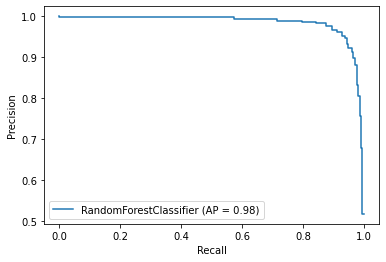

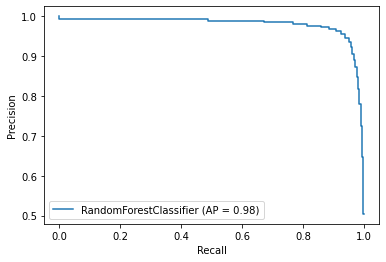

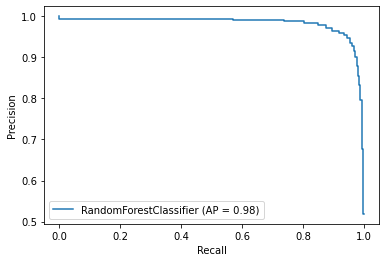

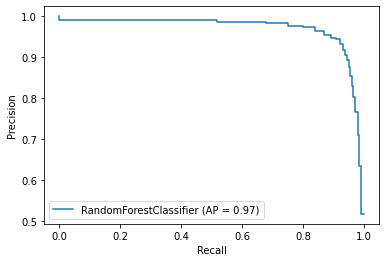

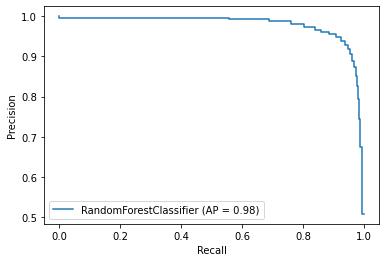

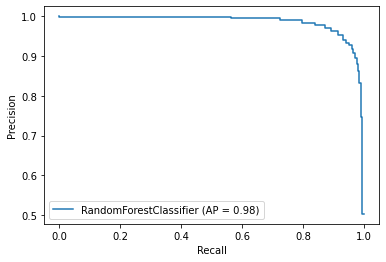

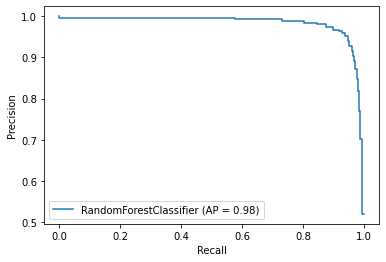

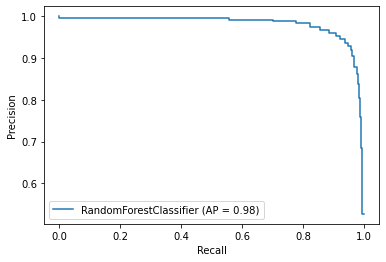

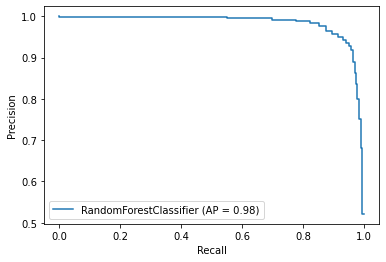

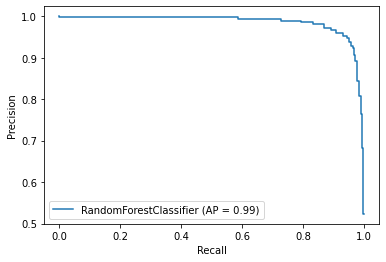

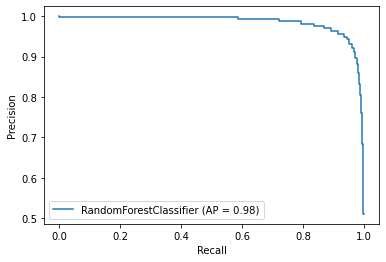

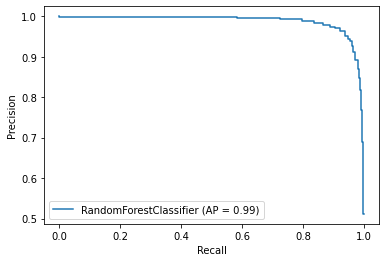

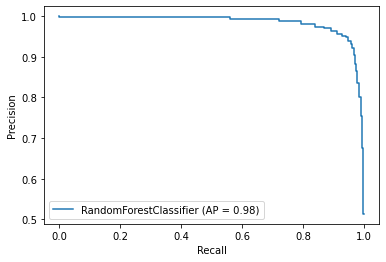

In [35]:
filtered_perf = []
for i, feature in enumerate(engineered_features):
    filtered_features = engineered_features[:i] + engineered_features[i+1:]
    f1 = classification_with_engineered_features(best_model, df, filtered_features)[1]
    filtered_perf.append([feature, f1, best_f1 - f1])

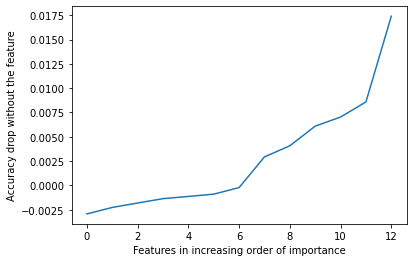

,feature,perf_without,accuracy_drop
3,date_int,92.86%,1.74%
4,text_relevant_word_ratio,93.74%,0.86%
7,text_exclamation_ratio,93.89%,0.70%
8,text_question_ratio,93.99%,0.61%
5,title_to_text_ratio,94.19%,0.41%
0,text_len,94.30%,0.29%
10,neu,94.62%,-0.02%
9,neg,94.69%,-0.09%
12,compound,94.71%,-0.11%
6,text_punct_ratio,94.73%,-0.14%


In [36]:
df_filtered_engineered_perf = pd.DataFrame(data=filtered_perf,columns=["feature","perf_without", "accuracy_drop"])
df_filtered_engineered_perf = df_filtered_engineered_perf.sort_values(by=['perf_without'])
df_filtered_engineered_perf_sorted = sorted(list(df_filtered_engineered_perf['accuracy_drop']))

plt.plot(df_filtered_engineered_perf_sorted)
plt.xlabel("Features in increasing order of importance")
plt.ylabel("Accuracy drop without the feature")
plt.show()

df_filtered_engineered_perf['perf_without'] = df_filtered_engineered_perf['perf_without'].apply(lambda x: f'{x:.2%}')
df_filtered_engineered_perf['accuracy_drop'] = df_filtered_engineered_perf['accuracy_drop'].apply(lambda x: f'{x:.2%}')
df_filtered_engineered_perf

<h2><b><u><font color="#60b060">9.2. Via Selection</font></u></b></h2>

<p>Let's find out the dip in accuracies by including only each individual feature to find their importance. </p>
<p>We see that this excercise is relatively helpful and that features like title length, date, and relevant word ratioare the most important features. Infact, using only the title length gives an accuracy of 78.5% which is pretty impressive!</p>

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 61.569% | F1: 65.863% | Weighted F1: 61.102% | Test F1: 61.083%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 78.024% | F1: 76.790% | Weighted F1: 77.926% | Test F1: 78.859%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 62.338% | F1: 66.497% | Weighted F1: 61.892% | Test F1: 62.118%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 73.415% | F1: 77.834% | Weighted F1: 72.501% | Test F1: 72.988%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 69.954% | F1: 70.756% | Weighted F1: 69.960% | Test F1: 70.095%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 69.379% | F1: 69.841% | Weighted F1: 69.385% | Test F1: 70.462%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 61.019% | F1: 62.586% | Weighted F1: 61.006% | Test F1: 61.289%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 62.524% | F1: 45.223% | Weighted F1: 57.988% | Test F1: 58.260%

Model: R

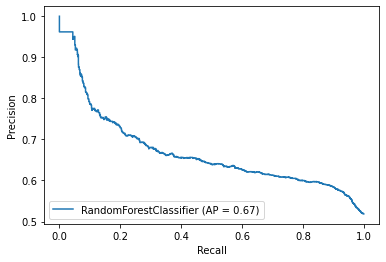

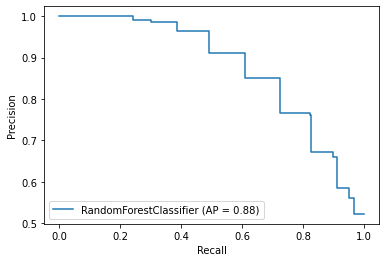

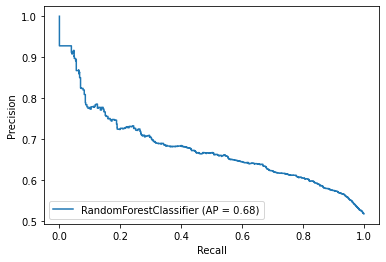

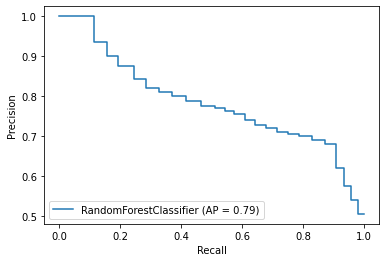

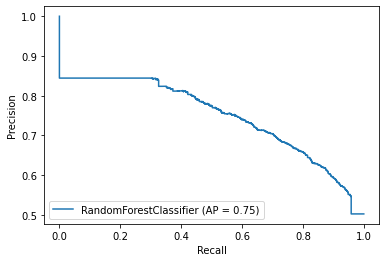

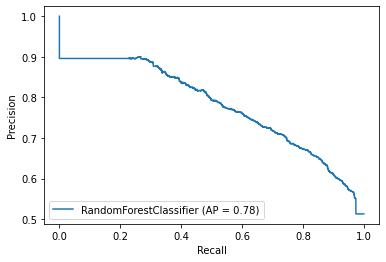

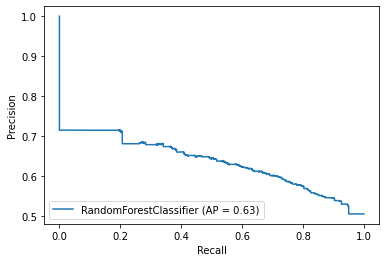

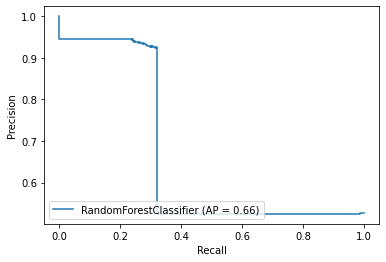

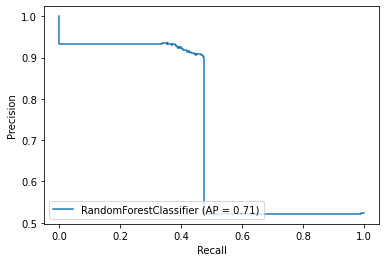

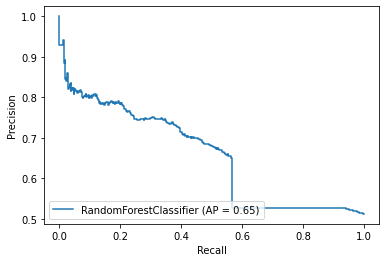

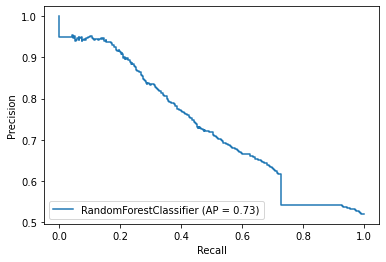

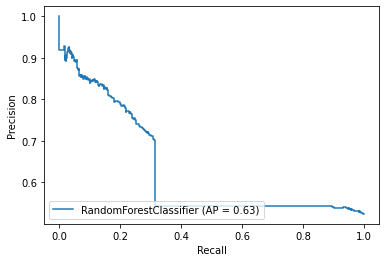

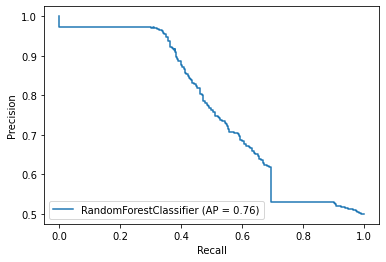

In [37]:
filtered_perf = []
for i, feature in enumerate(engineered_features):
    f1 = classification_with_engineered_features(best_model, df, [feature])[1]
    filtered_perf.append([feature, f1])

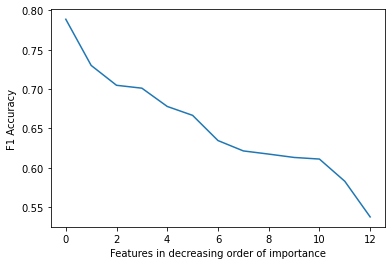

,feature,f1
1,title_len,0.788586
3,date_int,0.729884
5,title_to_text_ratio,0.704616
4,text_relevant_word_ratio,0.700950
8,text_question_ratio,0.677714
12,compound,0.666393
10,neu,0.634364
2,text_minus_stop_len,0.621178
9,neg,0.617153
6,text_punct_ratio,0.612886


In [38]:
df_individual_engineered_perf = pd.DataFrame(data=filtered_perf,columns=["feature", "f1"])
df_individual_engineered_perf = df_individual_engineered_perf.sort_values(by=['f1'], ascending=False)

plt.plot(list(df_individual_engineered_perf['f1']))
plt.xlabel("Features in decreasing order of importance")
plt.ylabel("F1 Accuracy")
plt.show()

df_individual_engineered_perf

<h2><b><u><font color="#60b060">9.3. Cumulative Performance</font></u></b></h2>

<p>Let's include the first N most important features obtained via selection to see when the performance plateaus to determine what features we can ignore completely.</p>
<p>We see that this excercise is very revealing that including the first 4 features gives us comparable accuracy (94%) to including all 13. This can be harnessed for larger data size</p>

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 78.160% | F1: 77.010% | Weighted F1: 78.070% | Test F1: 77.566%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 84.048% | F1: 84.074% | Weighted F1: 84.048% | Test F1: 83.301%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 85.316% | F1: 85.795% | Weighted F1: 85.315% | Test F1: 87.001%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 91.018% | F1: 91.248% | Weighted F1: 91.019% | Test F1: 91.546%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 92.673% | F1: 92.868% | Weighted F1: 92.674% | Test F1: 93.467%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.047% | F1: 93.238% | Weighted F1: 93.048% | Test F1: 94.032%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.190% | F1: 93.376% | Weighted F1: 93.191% | Test F1: 93.739%

Model: RandomForestClassifier(n_estimators=20) | Accuracy: 93.246% | F1: 93.447% | Weighted F1: 93.246% | Test F1: 93.761%

Model: R

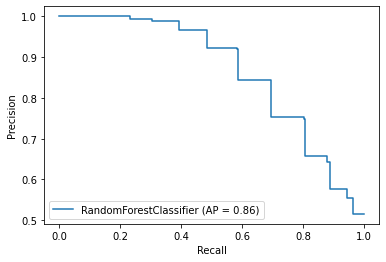

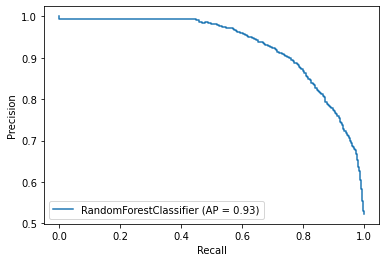

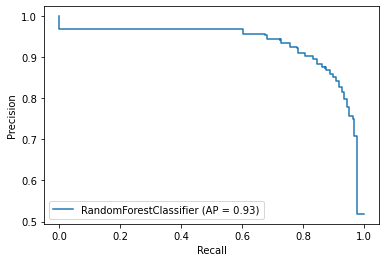

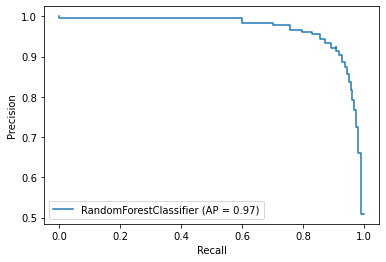

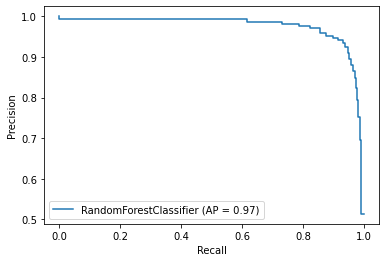

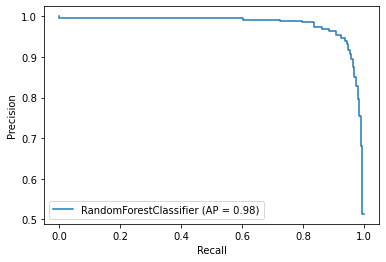

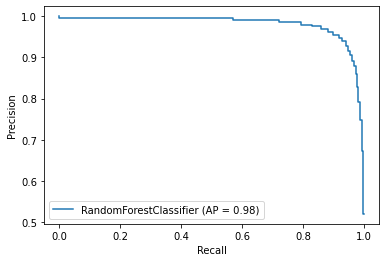

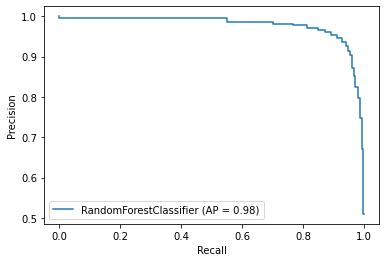

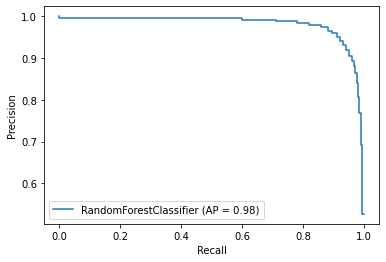

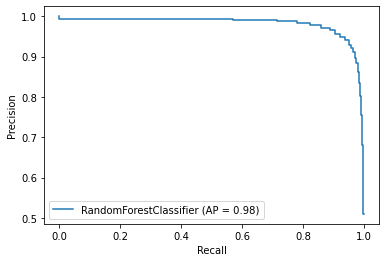

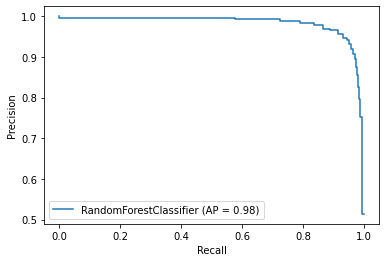

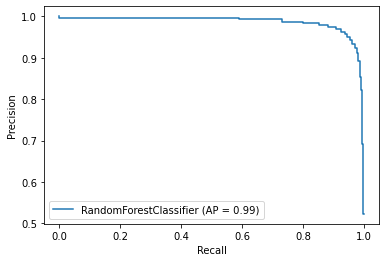

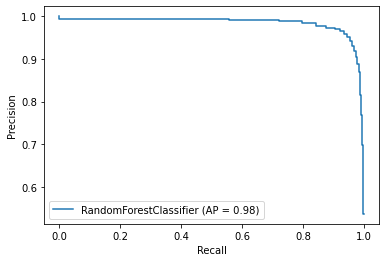

In [39]:
features = list(df_individual_engineered_perf['feature'])
filtered_perf = []
for i in range(len(features)):
    filtered_features = features[:i+1]
    f1 = classification_with_engineered_features(best_model, df, filtered_features)[1]
    filtered_perf.append(f1)

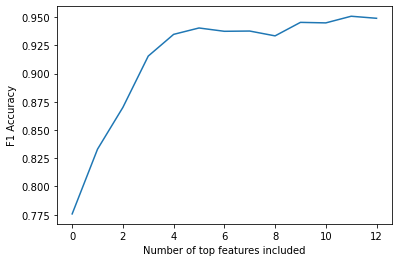

In [40]:
plt.plot(filtered_perf)
plt.xlabel("Number of top features included")
plt.ylabel("F1 Accuracy")
plt.show()

<h1><b><u><font color="#60b060">10. NGram Classification</font></u></b></h1>

<p>Let's now abandon the engineered features, and create a comprehensive classifier using the generated NGrams</p>

<h2><b><u><font color="#60b060">10.1. Model Picker</font></u></b></h2>

<p>This class is inspired by HW4 tests a combination of models, parameters and features to pick the best model</p>

In [41]:
class ModelPicker:

    def __init__(self, col_text, col_class, col_output, data, 
                 scoring, run_config, return_models_and_vectorizers=False):
        self.col_text = col_text
        self.col_class = col_class
        self.col_output = col_output
        self.scoring = scoring
        self.df_raw = data
        self.run_config = run_config
        self.return_models_and_vectorizers = return_models_and_vectorizers

    def compile(self):
        compiled = []

        i = 1
        for model_type in self.run_config["model_types"]:
            for features in self.run_config["feature_set"]:
                model_name = f"{model_type}_{features}"
                model, vectorizer, df_split = self.configure(model_type, features, self.df_raw)
                model, accuracy, f1_sc, f1_sc_wt = self.train(model, vectorizer, df_split)
                test_score = ModelPicker.test(model, vectorizer, df_split)
                model_info = [model_name, model_type, features, test_score, accuracy, f1_sc, f1_sc_wt]
                if self.return_models_and_vectorizers:
                    model_info.append(model)
                    model_info.append(vectorizer)
                compiled.append(model_info)
                print(f"Model: {model_name}, ACC: {accuracy:.2%}, F1: {f1_sc:.2%} ",
                      f"WF1: {f1_sc_wt:.2%}, TEST: {test_score:.2%}\n\n")
                i += 1
        columns = self.col_output
        if self.return_models_and_vectorizers:
            columns.append("model")
            columns.append("vectorizer")
        return pd.DataFrame(data=compiled, columns=columns)
    
    @staticmethod
    def get_vectorizer(features):
        ngram_range = None
        vectorizer = None
        if features in ["UNIGRAM", "TFIDF_UNIGRAM"]:
            ngram_range = (1, 1)
        elif features in ["UNIBIGRAM", "TFIDF_UNIBIGRAM"]:
            ngram_range = (1, 2)
        else:
            ngram_range = (1, 3)

        if "TFIDF_" in features:
            vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', 
                                         ngram_range=ngram_range)
        else:
            vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=5)
        
        return vectorizer
    
    def configure(self, model_type, features, data):
        model = None
        if model_type == "LR":
            model = LogisticRegression()
        elif model_type == "RF":
            model = RandomForestClassifier(n_estimators=10)
        elif "KNN" in model_type:
            model = KNeighborsClassifier(n_neighbors=3 if "_3" in model_type else 5)
        elif "SVM" in model_type:
            model = LinearSVC(loss="hinge")

        vectorizer = self.get_vectorizer(features)

        xtr, xts, ytr, yts = train_test_split(data[self.col_text], data[self.col_class], 
                                              test_size=0.15)
        
        return model, vectorizer, (xtr, xts, ytr, yts)

    def train(self, model, vectorizer, df_split):
        vect = vectorizer.fit(df_split[0]).transform(df_split[0])
        model.fit(vect, df_split[2])
        cv = cross_validate(estimator=model, X=vect, y=df_split[2], cv=5, scoring=self.scoring, return_train_score=True)
        return model, cv["test_acc"].mean(), cv["test_f1"].mean(), cv["test_f1_weighted"].mean()

    @staticmethod
    def test(model, vectorizer, df_split, plot_precision_recall=False):
        vect = vectorizer.fit(df_split[0]).transform(df_split[1])
        f1 = f1_score(df_split[3], model.predict(vect), average='weighted')
        if plot_precision_recall:
            plot_precision_recall_curve(model, vect, df_split[3]) # TODO: Shift to limited models
        return f1
    
    def predict(self, model, model_name, data):
        return model.predict(self.get_vectorizer(model_name).fit_transform(data[self.col_text]))


<h2><b><u><font color="#60b060">10.2. NGram classification on titles</font></u></b></h2>

<p>Since ngram classification is time sensitive, let's choose our model by simply using the titles for data.</p>

In [42]:
mp = ModelPicker(
    col_text="raw_title",
    col_class="class",
    col_output=["Model Name", "Model Type", "Features", "Test Score", 
                "Accuracy", "F1 Score", "Weighted F1"],
    data=df,
    scoring={
        "acc": make_scorer(accuracy_score),
        "f1": make_scorer(f1_score),
        "f1_weighted": make_scorer(f1_score, average="weighted")
    },
    run_config={
        "model_types": ["LR", "RF", "KNN_3", "KNN_5", "SVM"],
        "feature_set": ["UNIGRAM", "UNIBIGRAM", "UNIBITRIGRAM", 
                        "TFIDF_UNIGRAM", "TFIDF_UNIBIGRAM", "TFIDF_UNIBITRIGRAM"]
    }
)

result_df = mp.compile()

C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Model: LR_UNIGRAM, ACC: 95.27%, F1: 95.38%  WF1: 95.27%, TEST: 95.48%




C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Model: LR_UNIBIGRAM, ACC: 95.80%, F1: 95.91%  WF1: 95.80%, TEST: 96.04%




C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Model: LR_UNIBITRIGRAM, ACC: 95.76%, F1: 95.86%  WF1: 95.76%, TEST: 95.59%


Model: LR_TFIDF_UNIGRAM, ACC: 93.34%, F1: 93.53%  WF1: 93.33%, TEST: 94.09%


Model: LR_TFIDF_UNIBIGRAM, ACC: 93.32%, F1: 93.55%  WF1: 93.32%, TEST: 93.99%


Model: LR_TFIDF_UNIBITRIGRAM, ACC: 92.96%, F1: 93.22%  WF1: 92.96%, TEST: 93.86%


Model: RF_UNIGRAM, ACC: 91.69%, F1: 91.88%  WF1: 91.70%, TEST: 92.99%


Model: RF_UNIBIGRAM, ACC: 92.12%, F1: 92.28%  WF1: 92.12%, TEST: 92.92%


Model: RF_UNIBITRIGRAM, ACC: 91.95%, F1: 92.06%  WF1: 91.95%, TEST: 92.92%


Model: RF_TFIDF_UNIGRAM, ACC: 91.37%, F1: 91.46%  WF1: 91.37%, TEST: 92.24%


Model: RF_TFIDF_UNIBIGRAM, ACC: 91.86%, F1: 91.98%  WF1: 91.87%, TEST: 90.54%


Model: RF_TFIDF_UNIBITRIGRAM, ACC: 92.06%, F1: 92.18%  WF1: 92.06%, TEST: 89.11%


Model: KNN_3_UNIGRAM, ACC: 69.80%, F1: 70.38%  WF1: 69.76%, TEST: 71.10%


Model: KNN_3_UNIBIGRAM, ACC: 70.02%, F1: 67.42%  WF1: 69.68%, TEST: 69.27%


Model: KNN_3_UNIBITRIGRAM, ACC: 67.02%, F1: 67.52%  WF1: 66.61%, T

C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model: SVM_UNIGRAM, ACC: 95.07%, F1: 95.17%  WF1: 95.07%, TEST: 94.91%


Model: SVM_UNIBIGRAM, ACC: 95.15%, F1: 95.28%  WF1: 95.16%, TEST: 95.93%


Model: SVM_UNIBITRIGRAM, ACC: 95.19%, F1: 95.31%  WF1: 95.19%, TEST: 95.53%


Model: SVM_TFIDF_UNIGRAM, ACC: 94.05%, F1: 94.21%  WF1: 94.05%, TEST: 93.85%


Model: SVM_TFIDF_UNIBIGRAM, ACC: 94.90%, F1: 95.06%  WF1: 94.90%, TEST: 95.87%


Model: SVM_TFIDF_UNIBITRIGRAM, ACC: 94.86%, F1: 95.02%  WF1: 94.86%, TEST: 95.73%




In [43]:
result_df

,Model Name,Model Type,Features,Test Score,Accuracy,F1 Score,Weighted F1
0,LR_UNIGRAM,LR,UNIGRAM,0.954801,0.952713,0.953817,0.952722
1,LR_UNIBIGRAM,LR,UNIBIGRAM,0.960368,0.958005,0.959086,0.958013
2,LR_UNIBITRIGRAM,LR,UNIBITRIGRAM,0.955855,0.957606,0.958642,0.957614
3,LR_TFIDF_UNIGRAM,LR,TFIDF_UNIGRAM,0.940931,0.933351,0.935288,0.933350
4,LR_TFIDF_UNIBIGRAM,LR,TFIDF_UNIBIGRAM,0.939863,0.933218,0.935483,0.933211
5,LR_TFIDF_UNIBITRIGRAM,LR,TFIDF_UNIBITRIGRAM,0.938641,0.929601,0.932181,0.929584
6,RF_UNIGRAM,RF,UNIGRAM,0.929943,0.916941,0.918786,0.916956
7,RF_UNIBIGRAM,RF,UNIBIGRAM,0.929179,0.921197,0.922750,0.921218
8,RF_UNIBITRIGRAM,RF,UNIBITRIGRAM,0.929202,0.919468,0.920589,0.919480
9,RF_TFIDF_UNIGRAM,RF,TFIDF_UNIGRAM,0.922424,0.913697,0.914578,0.913712


In [44]:
best_params_by_title = result_df.loc[result_df["Test Score"].idxmax()]
print(
    f"\nBest custom model: {best_params_by_title['Model Name']}",
    f"\nTest Weighted F1: {best_params_by_title['Test Score']:.3%}"
)


Best custom model: LR_UNIBIGRAM 
Test Weighted F1: 96.037%


<h2><b><u><font color="#60b060">10.3. NGram classification on text</font></u></b></h2>

<p>Let's use the best model to now do a full ngram classification on the text.</p>

In [45]:
mp_full_text = ModelPicker(
    col_text="raw_text",
    col_class="class",
    col_output=["Model Name", "Model Type", "Features", "Test Score", 
                "Accuracy", "F1 Score", "Weighted F1"],
    data=df,
    scoring={
        "acc": make_scorer(accuracy_score),
        "f1": make_scorer(f1_score),
        "f1_weighted": make_scorer(f1_score, average="weighted")
    },
    run_config={"model_types": ["LR"],"feature_set": ["UNIBITRIGRAM"]},
    return_models_and_vectorizers=True
)

result_full_text_df = mp_full_text.compile()

C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sanket\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Model: LR_UNIBITRIGRAM, ACC: 98.88%, F1: 98.91%  WF1: 98.88%, TEST: 99.19%




In [46]:
result_full_text_df

,Model Name,Model Type,Features,Test Score,Accuracy,F1 Score,Weighted F1,model,vectorizer
0,LR_UNIBITRIGRAM,LR,UNIBITRIGRAM,0.991863,0.988777,0.989098,0.988777,LogisticRegression(),"CountVectorizer(min_df=5, ngram_range=(1, 3))"


In [47]:
best_params_by_text = result_full_text_df.loc[result_full_text_df["Test Score"].idxmax()]
best_model_name = best_params_by_text['Model Name']
print(
    f"\nBest custom model: {best_model_name}",
    f"\nTest Weighted F1: {best_params_by_text['Test Score']:.3%}"
)


Best custom model: LR_UNIBITRIGRAM 
Test Weighted F1: 99.186%


<h1><b><u><font color="#60b060">11. A Compact Fake News Detection Function</font></u></b></h1>

<p>Let's compile all our efforts to create a final function that reads and classifies a text file article</p>

<h2><b><u><font color="#60b060">11.1. Model Persistence</font></u></b></h2>

<p>Let's export the model for ease of future use</p>

In [48]:
dump(result_full_text_df.loc[0, "model"], f'{best_model_name}.model.joblib')
dump(result_full_text_df.loc[0, "vectorizer"], f'{best_model_name}.vectorizer.joblib')

['LR_UNIBITRIGRAM.vectorizer.joblib']

In [49]:
jlmodel = load(f'{best_model_name}.model.joblib')
jlvec = load(f'{best_model_name}.vectorizer.joblib')

<h2><b><u><font color="#60b060">11.2. The Function</font></u></b></h2>

<p>This function imports the model, vectorizer, and a sample text file to output whether it is real or fake</p>

In [76]:
def check_news_validity(model, vectorizer, text_path):
    with open(text_path, "r") as f:
        texts  = f.readlines()
        f.close()
        print("Text file read")

        if type(model) is str:
            model = load(model)  
            print("Model loaded")
        
        if type(vectorizer) is str:
            vectorizer = load(vectorizer_path)
            print("Vectorizer loaded")
        
        validities = ["Real" if i == 0 else "Fake" for i in jlmodel.predict(jlvec.transform(texts))]
        return list(zip(texts, validities))

<h1><b><u><font color="#60b060">12. Fake News Generator using RNN/LSTM</font></u></b></h1>

<p>This is just a thought experiment and is not meant to test out RNN/LSTM model in any way. We use the fake news corpus to train an RNN to generate fake news titles. Next, we pass them through our classifier and see that it successfully identifies them all as fake. Note this this is partly due to the imperfections of the RNN model giving an overall informal tone.</p>

In [77]:
for t, v in check_news_validity(jlmodel, jlvec, "basic_rnn_output.2.txt"):
    print(f"{t} --> {v}\n")

Text file read
FAKE NEWS:aIE:neW : argent contrusinist suppeal to rise pot as formation calls over trimine panaper of says it warns
 --> Fake

"Trump proposals"
 --> Fake

Senate deal and security at that after mathings
 --> Fake

U.S. see telied of Upistan expent support to cut as shows official on closers
 --> Fake

Supreme emptry to surprising frinations of conspercent to brutally asks
 --> Fake

"Trump secretary termation says to attens
 --> Fake

Syrians travel bastance of confespares as toll for promised to court relia says will not as as for securifus at deash saying after transgender
 --> Fake

Trump conservativistic politics in persuri talks
 --> Fake

Secomiands on tax rush repeal to cubs
 --> Fake

Congress of U.N. to seeks wing trimptens sees are police onesiderers stop
 --> Fake

Secret over senator missileare cash
 --> Fake

Senate pressuring affected arrested plan to cut and concerning anti-lawmakers at Clinton to see charged tax reform tary says wire stupe' after mather

<h1 align='center'><b><u><font color="#60b060">THE END</font></u></b></h1>